In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import seaborn as sns
import os
import os.path as osp
import sys
import pickle
import joblib
from collections import Counter
from itertools import product
import torch
import pdb
import random
import tables
from sklearn.linear_model import LogisticRegression, LinearRegression
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, average_precision_score,\
balanced_accuracy_score
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.calibration import CalibratedClassifierCV
import heckman
from heckman import Heckman
import wandb
from wandb.lightgbm import wandb_callback, log_summary
from dill.source import getsource
from dill import detect
import functools
from copy import deepcopy

### set the seeds and change to current directory + set the output directory

In [2]:
SEED=90210
np.random.seed(SEED)
os.environ['USER_PATH']='/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/'
os.environ['OUT_PATH']='/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/output_directory'

### Create function to pickle functions

In [3]:
def function_to_string(fn):
    return getsource(detect.code(fn)) 

In [4]:
processed_data_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk')

In [5]:
os.chdir('/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/')
from AnalysisFuncs import trainEvalModel, trainHardPseudo, loadFile, saveFile, calibrate_by_bin
from AnalysisFuncs import getTrainTestIdx, plotCalibrationPlots, getClippedProbs

In [6]:
%reload_ext autoreload
%autoreload 2

In [7]:
train_X = loadFile(osp.join(processed_data_path,'predict_T'), '/train_X.npy')
train_y_T = loadFile(osp.join(processed_data_path,'predict_T'), '/train_y_T.npy')
val_X = loadFile(osp.join(processed_data_path,'predict_T'), '/val_X.npy')
val_y_T = loadFile(osp.join(processed_data_path,'predict_T'), '/val_y_T.npy')
train_cross_val_X = loadFile(osp.join(processed_data_path,'predict_T'), '/train_cross_val_X.npy')
train_cross_val_y_T = loadFile(osp.join(processed_data_path,'predict_T'), '/train_cross_val_y_T.npy')
test_X = loadFile(osp.join(processed_data_path,'predict_T'), '/test_X.npy')
test_y_T = loadFile(osp.join(processed_data_path,'predict_T'), '/test_y_T.npy')

train_X_D_given_T = loadFile(osp.join(processed_data_path,'predict_D_given_T'), '/train_X_D_given_T.npy')
train_y_D_given_T = loadFile(osp.join(processed_data_path,'predict_D_given_T'), '/train_y_D_given_T.npy')
val_X_D_given_T = loadFile(osp.join(processed_data_path,'predict_D_given_T'), '/val_X_D_given_T.npy')
val_y_D_given_T = loadFile(osp.join(processed_data_path,'predict_D_given_T'), '/val_y_D_given_T.npy')
train_cross_val_X_D_given_T = loadFile(osp.join(processed_data_path,'predict_D_given_T'), 
                                       '/train_cross_val_X_D_given_T.npy')
train_cross_val_y_D_given_T = loadFile(osp.join(processed_data_path,'predict_D_given_T'), 
                                       '/train_cross_val_y_D_given_T.npy')
test_X_D_given_T = loadFile(osp.join(processed_data_path,'predict_D_given_T'), '/test_X_D_given_T.npy')
test_y_D_given_T = loadFile(osp.join(processed_data_path,'predict_D_given_T'), '/test_y_D_given_T.npy')



train_y_D_and_T = loadFile(osp.join(processed_data_path,'predict_D_and_T'), '/train_y_D_and_T.npy')
val_y_D_and_T = loadFile(osp.join(processed_data_path,'predict_D_and_T'), '/val_y_D_and_T.npy')
train_cross_val_y_D_and_T = loadFile(osp.join(processed_data_path,'predict_D_and_T'), 
                                       '/train_cross_val_y_D_and_T.npy')
test_y_D_and_T = loadFile(osp.join(processed_data_path,'predict_D_and_T'), '/test_y_D_and_T.npy')

In [8]:
df_cleaned = loadFile(processed_data_path, 'df_cleaned.csv')
df_sf = loadFile(processed_data_path, 'processed_df.csv')
features = loadFile(processed_data_path, 'features.pkl')
test_idxs_original = loadFile(processed_data_path, '/test_idxs.npy')
cal_idxs, test_idxs = getTrainTestIdx(df=df_sf.iloc[test_idxs_original].copy(), train_size=0.5)

# ensure that cal and test idxs are absolute w.r.t dataframe
assert len(np.intersect1d(cal_idxs, test_idxs_original))==len(cal_idxs)
assert len(np.intersect1d(test_idxs, test_idxs_original))==len(test_idxs)

train_idxs = loadFile(processed_data_path, '/train_idxs.npy')
val_idxs = loadFile(processed_data_path, '/val_idxs.npy')
tr=len(train_idxs)
v=len(val_idxs)
t=len(test_idxs)
cal=len(cal_idxs)
assert (tr+v+cal+t)==len(df_sf)
assert len(np.intersect1d(train_idxs, val_idxs))==0
assert len(np.intersect1d(test_idxs, val_idxs))==0
assert len(np.intersect1d(train_idxs, test_idxs))==0
assert len(np.intersect1d(train_idxs, cal_idxs))==0
assert len(np.intersect1d(test_idxs, cal_idxs))==0
assert len(np.intersect1d(val_idxs, cal_idxs))==0
print(f"train %:{tr*100/(tr+v+cal+t):.2f}, val %:{v*100/(tr+v+cal+t):.2f}, cal %:{cal*100/(tr+v+cal+t):.2f}, test %:{t*100/(tr+v+cal+t):.2f}")

/home/rr568/.conda/envs/icu-benchmark/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (67) have mixed types.Specify dtype option on import or set low_memory=False.
  if await self.run_code(code, result, async_=asy):


train %:45.00, val %:5.00, cal %:25.00, test %:25.00


In [9]:
#load features and df_sf
cal_X = np.array(df_sf.iloc[cal_idxs][features].reset_index(drop=True))
cal_X=cal_X.astype(float)
test_X = np.array(df_sf.iloc[test_idxs][features].reset_index(drop=True))
assert ~pd.isna(df_sf.iloc[test_idxs][features].reset_index(drop=True)).isnull().values.any()
test_X=test_X.astype(float)

test_X_D_given_T = np.array(df_sf.iloc[test_idxs].loc[df_sf['T']==1][features].reset_index(drop=True).astype(float))
test_y_T = df_sf.iloc[test_idxs]['T'].values.astype(int)
test_y_D_given_T = df_sf.iloc[test_idxs].loc[df_sf['T']==1]['D'].values.astype(int)
test_y_D_and_T = df_sf.iloc[test_idxs]['D_and_T'].values.astype(int)

assert ~pd.isna(df_sf.iloc[cal_idxs][features].reset_index(drop=True)).isnull().values.any()
cal_y_T = df_sf.iloc[cal_idxs]['T'].values.astype(int)

In [10]:
# load the best params as pickle if they exist , if not use the default settings
random_state=0
bst_params_T_LR={'random_state': random_state, 
              'solver': 'liblinear', 
              'penalty':  'l1',
                }
bst_params_T_LGBM={'random_state': random_state, 
                  }
LR_T = LogisticRegression(**bst_params_T_LR)
LGBM_T = LGBMClassifier(**bst_params_T_LGBM)

bst_params_D_given_T_LR = {'random_state': random_state, 
                      'solver': 'liblinear', 
                      'penalty':  'l1',
                       }
# bst_params_D_given_T_LGBM={'random_state': random_state, 
#                   }
bst_params_D_given_T_LGBM = {'bagging_fraction': 0.7892603819633417, 'feature_fraction': 0.5283564886587215, 
             'max_depth': 5, 'min_child_samples': 30, 'max_bin':63, 'num_leaves':15,
                            'min_data_in_leaf':100}
LR_D_given_T = LogisticRegression(**bst_params_D_given_T_LR)
LR_D_given_T_ipw = LogisticRegression(**bst_params_D_given_T_LR)
LGBM_D_given_T = LGBMClassifier(**bst_params_D_given_T_LGBM)
LGBM_D_given_T_ipw = LGBMClassifier(**bst_params_D_given_T_LGBM)
bst_params_D_and_T_LR = {'random_state': random_state, 
                      'solver': 'liblinear', 
                      'penalty':  'l1',
                     }
bst_params_D_and_T_LGBM={'random_state': random_state, 
                  }
LR_D_and_T = LogisticRegression(**bst_params_D_and_T_LR)
LGBM_D_and_T = LGBMClassifier(**bst_params_D_and_T_LGBM)

In [11]:
# calibrate_method='calibrate_by_bins'
calibrate_method='sigmoid'
#use calibration method in the path to save the model
processed_data_path = osp.join(processed_data_path, calibrate_method)
print(processed_data_path)
from sklearn.model_selection import StratifiedKFold
cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/output_directory/stop_and_frisk/sigmoid


In [12]:
#save new test_idxs
saveFile(osp.join(processed_data_path,'after_cal'), test_idxs, '/test_idxs.npy')
saveFile(osp.join(processed_data_path,'after_cal'), cal_idxs, '/cal_idxs.npy')
saveFile(osp.join(processed_data_path,'after_cal'), test_X, '/test_X.npy')
saveFile(osp.join(processed_data_path,'after_cal'), cal_X, '/cal_X.npy')
saveFile(osp.join(processed_data_path,'after_cal'), test_y_T, '/test_y_T.npy')
saveFile(osp.join(processed_data_path,'after_cal'), test_y_D_given_T, '/test_y_D_given_T.npy')
saveFile(osp.join(processed_data_path,'after_cal'), test_y_D_and_T, '/test_y_D_and_T.npy')

In [14]:
model_descr="predicting T using Logistic Regression"
LR_T, test_proba_LR_T = trainEvalModel(LR_T, train_cross_val_X, train_cross_val_y_T.copy(), test_X.copy(),
                                       test_y_T.copy(), 
                                       model_descr, calibrate=True, calibrate_method=calibrate_method)

model_descr="predicting D|T using Logistic Regression"
LR_D_given_T, test_proba_LR_D_given_T = trainEvalModel(LR_D_given_T, train_cross_val_X_D_given_T.copy(), 
                    train_cross_val_y_D_given_T.copy(), test_X_D_given_T.copy(), test_y_D_given_T.copy(), model_descr, 
                                                       calibrate=True, calibrate_method=calibrate_method)


AUC score :predicting T using Logistic Regression: 0.818
AUPR score :predicting T using Logistic Regression: 0.853
AUC score :predicting D|T using Logistic Regression: 0.804
AUPR score :predicting D|T using Logistic Regression: 0.251


In [15]:
#save LR models
saveFile(osp.join(processed_data_path,'predict_T'), LR_T, 'LR_T.pkl')
saveFile(osp.join(processed_data_path,'predict_D_given_T'), LR_D_given_T, 'LR_D_given_T.pkl')

In [13]:
model_descr="predicting T using LGBM"
LGBM_T, test_proba_LGBM_T = trainEvalModel(LGBM_T, train_cross_val_X.copy(), train_cross_val_y_T.copy(), 
                                           test_X.copy(), test_y_T.copy(), 
                                       model_descr, calibrate=True, calibrate_method=calibrate_method, cv=cv)


AUC score :predicting T using LGBM: 0.833
AUPR score :predicting T using LGBM: 0.866


In [14]:
# save LGBM models
saveFile(osp.join(processed_data_path,'predict_T'), LGBM_T, 'LGBM_T.pkl')

In [15]:
model_descr="predicting D|T using LGBM"
LGBM_D_given_T, test_proba_LGBM_D_given_T = trainEvalModel(LGBM_D_given_T, train_cross_val_X_D_given_T.copy(), 
                    train_cross_val_y_D_given_T.copy(), test_X_D_given_T.copy(), test_y_D_given_T.copy(), model_descr,
                    calibrate=True, calibrate_method=calibrate_method, cv=cv)

[LightGBM] [Warning] bagging_fraction is set=0.7892603819633417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7892603819633417
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5283564886587215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5283564886587215
[LightGBM] [Warning] bagging_fraction is set=0.7892603819633417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7892603819633417
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5283564886587215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5283564886587215
[LightGBM] [Warning] bagging_fraction is set=0.7892603819633417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7892603819633417
[Li

In [16]:
saveFile(osp.join(processed_data_path,'predict_D_given_T'), LGBM_D_given_T, 'LGBM_D_given_T.pkl')

In [20]:
model_descr="predicting D,T using Logistic Regression"
LR_D_and_T, test_proba_LR_D_and_T = trainEvalModel(LR_D_and_T, train_cross_val_X.copy(), 
                    train_cross_val_y_D_and_T.copy(), test_X.copy(), test_y_D_and_T.copy(), model_descr, 
                                        calibrate=True, calibrate_method=calibrate_method)


AUC score :predicting D,T using Logistic Regression: 0.846
AUPR score :predicting D,T using Logistic Regression: 0.220


In [21]:
saveFile(osp.join(processed_data_path,'predict_D_and_T'), LR_D_and_T, 'LR_D_and_T.pkl')

In [17]:
model_descr="predicting D,T using LGBM"
LGBM_D_and_T, test_proba_LGBM_D_and_T = trainEvalModel(LGBM_D_and_T, train_cross_val_X.copy(), 
                    train_cross_val_y_D_and_T.copy(), test_X.copy(), test_y_D_and_T.copy(), model_descr, 
                                                       calibrate=True, calibrate_method=calibrate_method)

AUC score :predicting D,T using LGBM: 0.867
AUPR score :predicting D,T using LGBM: 0.249


In [18]:
saveFile(osp.join(processed_data_path,'predict_D_and_T'), LGBM_D_and_T, 'LGBM_D_and_T.pkl')

calibrating by bins using cal data
val max:27664, val min:27663
 number of bins in test :20
calibrated_preds
0.126952    0.125737
0.178824    0.173446
0.215812    0.218821
0.262580    0.255341
0.293388    0.301040
0.339286    0.339453
0.379713    0.381402
0.427089    0.428748
0.472942    0.474189
0.521544    0.525199
0.578535    0.575320
0.643219    0.642154
0.704624    0.701740
0.771508    0.767148
0.820157    0.823775
0.856962    0.859911
0.879117    0.882906
0.907136    0.908229
0.930232    0.931237
0.960671    0.961938
Name: ground_truth, dtype: float64
AUC score :predicting D|T_IPW using Logistic Regression: 0.804
AUPR score :predicting D|T_IPW using Logistic Regression: 0.250


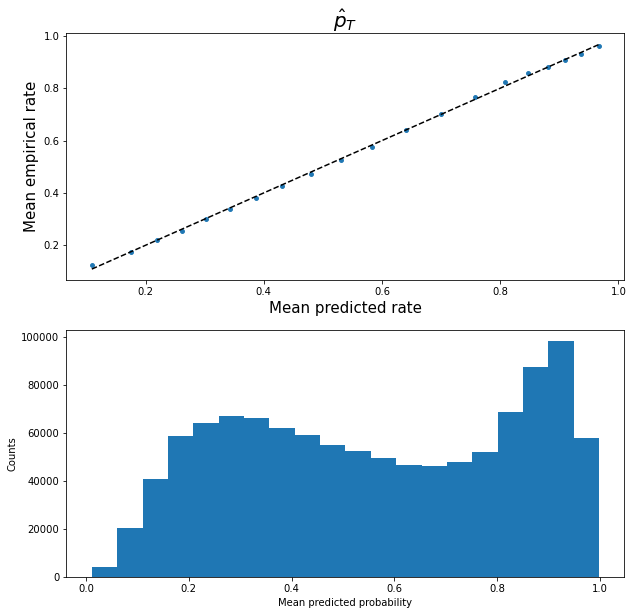

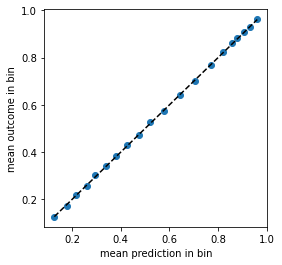

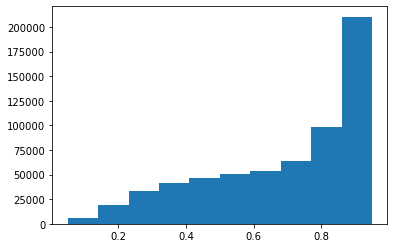

In [24]:
model_descr="predicting D|T_IPW using Logistic Regression"
train_X_D_given_T_probs_LR, train_cross_val_X_ipw = getClippedProbs(LR_T, 
                    train_cross_val_X.copy(), train_cross_val_y_T.copy(), cal_X=cal_X, cal_y_T=cal_y_T)
np.testing.assert_array_equal(train_cross_val_X_ipw, train_cross_val_X_D_given_T)
LR_D_given_T_ipw, test_proba_LR_D_given_T_ipw = trainEvalModel(LR_D_given_T_ipw, train_cross_val_X_ipw.copy(), 
                    train_cross_val_y_D_given_T.copy(), test_X_D_given_T.copy(),
                    test_y_D_given_T.copy(), model_descr,
                    calibrate=False, calibrate_method=calibrate_method, 
                    sample_weight=1/train_X_D_given_T_probs_LR.copy())

In [25]:
saveFile(osp.join(processed_data_path,'predict_D_given_T_ipw'), LR_D_given_T_ipw, 'LR_D_given_T_ipw.pkl')

calibrating by bins using cal data
val max:27664, val min:27663
 number of bins in test :20
calibrated_preds
0.092105    0.087270
0.156593    0.155737
0.199400    0.195919
0.245807    0.246350
0.293208    0.291514
0.331405    0.333225
0.373712    0.376261
0.421342    0.419078
0.468026    0.468351
0.519412    0.526485
0.586524    0.586964
0.650051    0.644670
0.709504    0.712139
0.781087    0.779061
0.832122    0.832519
0.870120    0.869907
0.899252    0.903366
0.923294    0.928285
0.947945    0.949016
0.969383    0.970608
Name: ground_truth, dtype: float64
[LightGBM] [Warning] bagging_fraction is set=0.7892603819633417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7892603819633417
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5283564886587215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5283564886587215
[LightGBM] 

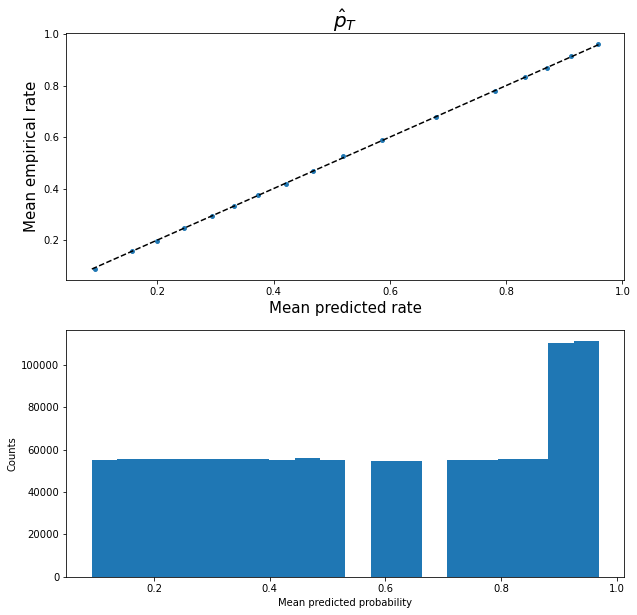

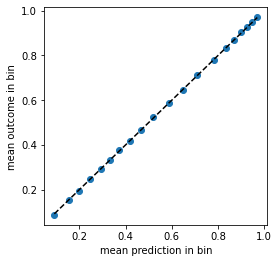

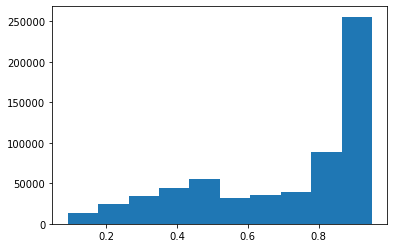

In [19]:
model_descr="predicting D|T_IPW using LGBM"
train_X_D_given_T_probs_LGBM, train_cross_val_X_ipw = getClippedProbs(LGBM_T, 
                    train_cross_val_X.copy(), train_cross_val_y_T.copy(), cal_X=cal_X, cal_y_T=cal_y_T)
np.testing.assert_array_equal(train_cross_val_X_ipw, train_cross_val_X_D_given_T)
LGBM_D_given_T_ipw, test_proba_LGBM_D_given_T_ipw = trainEvalModel(LGBM_D_given_T_ipw, train_cross_val_X_ipw.copy(), 
                    train_cross_val_y_D_given_T.copy(), test_X_D_given_T.copy(),
                    test_y_D_given_T.copy(), model_descr,
                    calibrate=True, calibrate_method=calibrate_method,
                    sample_weight=1/train_X_D_given_T_probs_LGBM.copy())

In [20]:
saveFile(osp.join(processed_data_path,'predict_D_given_T_ipw'), LGBM_D_given_T_ipw, 'LGBM_D_given_T_ipw.pkl')

In [21]:
random_state=0
bst_params_D_pseudo_LR = bst_params_D_given_T_LR
bst_params_D_pseudo_LGBM = bst_params_D_given_T_LGBM
LR_D_pseudo = LogisticRegression(**bst_params_D_pseudo_LR)
LGBM_D_pseudo = LGBMClassifier(**bst_params_D_pseudo_LGBM)

In [29]:
#predict the outcomes
#should be using copy and deepcopy ?

#assert that the pseudo labels are only binary in nature and not probs
train_cross_val_idxs=np.concatenate((train_idxs, val_idxs))
LR_D_pseudo, test_probs_D_pseudo_LR = trainHardPseudo(deepcopy(LR_D_given_T), df_cleaned.copy(), train_idxs.copy(), 
                                                      val_idxs.copy(),
                        train_X.copy(), val_X.copy(), deepcopy(LR_D_given_T), test_X_D_given_T.copy(),
                                                      test_y_D_given_T.copy(), 
                        model_descr="Logistic Regression with hard pseudo labels", 
                                                      calibrate=False, calibrate_method=calibrate_method)

AUC score :Logistic Regression with hard pseudo labels: 0.801
AUPR score :Logistic Regression with hard pseudo labels: 0.252


In [30]:
#save LR models
saveFile(osp.join(processed_data_path,'predict_D_pseudo'), LR_D_pseudo, 'LR_D_pseudo.pkl')

In [22]:
LGBM_D_pseudo, test_probs_D_pseudo_LGBM = trainHardPseudo(deepcopy(LGBM_D_given_T), df_cleaned.copy(), 
                        train_idxs.copy(), val_idxs.copy(), train_X.copy(), val_X.copy(),
                        deepcopy(LGBM_D_given_T), test_X_D_given_T.copy(),test_y_D_given_T.copy(), 
                        model_descr="LGBM with hard pseudo labels", 
                        calibrate=True, calibrate_method=calibrate_method)

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
[LightGBM] [Warning] bagging_fraction is set=0.7892603819633417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7892603819633417
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5283564886587215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5283564886587215
[LightGBM] [Warning] bagging_fraction is set=0.7892603819633417, subsample=

[LightGBM] [Warning] bagging_fraction is set=0.7892603819633417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7892603819633417
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5283564886587215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5283564886587215
[LightGBM] [Warning] bagging_fraction is set=0.7892603819633417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7892603819633417
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5283564886587215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5283564886587215
[LightGBM] [Warning] bagging_fraction is set=0.7892603819633417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7892603819633417
[Li

In [23]:
# save LGBM models
saveFile(osp.join(processed_data_path,'predict_D_pseudo'), LGBM_D_pseudo, 'LGBM_D_pseudo.pkl')